<a href="https://colab.research.google.com/github/mnfibin/AI-ML-Internship-Elevate_Labs/blob/main/Task%204/notebook/logistic_regression_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Logistic Regression Binary Classification (Breast Cancer Wisconsin Dataset)**

In [20]:
#Importing the Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, roc_auc_score, ConfusionMatrixDisplay,
                             precision_recall_curve)

> ## **1. Load and Explore Data**

In [21]:
def load_data(filepath):
    """
    Loads the dataset and performs basic cleaning.
    """
    print("Loading dataset...")
    # Load data
    df = pd.read_csv(filepath)

    # Clean data
    # Drop 'id' as it's not a feature
    if 'id' in df.columns:
        df = df.drop('id', axis=1)

    # The dataset often has a trailing empty column named 'Unnamed: 32' due to csv formatting
    if 'Unnamed: 32' in df.columns:
        df = df.drop('Unnamed: 32', axis=1)

    # Encode Target Variable: 'M' (Malignant) -> 1, 'B' (Benign) -> 0
    # It's crucial for binary classification to have 0/1 targets
    df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

    print(f"Data loaded successfully. Shape: {df.shape}")
    print("Class distribution:\n", df['diagnosis'].value_counts())
    return df

> ## **2. Preprocessing**

In [22]:
def preprocess_data(df):
    """
    Splits data into features/target, train/test sets, and scales features.
    """
    # Split Features (X) and Target (y)
    X = df.drop('diagnosis', axis=1)
    y = df['diagnosis']

    # Train/Test Split (80% Train, 20% Test)
    # random_state ensures reproducibility
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardization
    # Logistic Regression is sensitive to the scale of input features.
    # We use StandardScaler to transform features to have mean=0 and variance=1.
    scaler = StandardScaler()

    # Fit on training set ONLY to prevent data leakage
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, X.columns

> ## **3. Model Training**

In [23]:
def train_model(X_train, y_train):
    """
    Fits the Logistic Regression model.
    """
    print("\nTraining Logistic Regression Model...")
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    print("Model training complete.")
    return model

> ## **4. Evaluation**

In [24]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model using Confusion Matrix, ROC-AUC, and Classification Report.
    """
    print("\n--- Evaluation Metrics ---")

    # Predictions (Class labels: 0 or 1)
    y_pred = model.predict(X_test)

    # Probability predictions (floats between 0 and 1) needed for ROC-AUC
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])

    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # 2. Classification Report (Precision, Recall, F1-Score)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))

    # 3. ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_score:.2f})', color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Diagonal random classifier
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return y_pred_proba

> ## **5. Sigmoid & Threshold Tuning**

In [25]:
def plot_sigmoid_function():
    """
    Visualizes the Sigmoid function to explain how Logistic Regression works.
    """
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    z = np.linspace(-10, 10, 100)
    phi_z = sigmoid(z)

    plt.figure(figsize=(8, 5))
    plt.plot(z, phi_z, color='purple')
    plt.axvline(0.0, color='k')
    plt.axhspan(0.0, 1.0, facecolor='1.0', alpha=1.0, ls='dotted')
    plt.axhline(y=0.5, ls='dotted', color='k')
    plt.yticks([0.0, 0.5, 1.0])
    plt.ylim(-0.1, 1.1)
    plt.title('Sigmoid Function (S-Curve)')
    plt.xlabel('z (Linear Combination of Features)')
    plt.ylabel('$\phi (z)$ (Probability)')
    plt.text(4, 0.6, r'Probability $\geq$ 0.5 $\rightarrow$ Class 1', fontsize=10)
    plt.text(-8, 0.3, r'Probability < 0.5 $\rightarrow$ Class 0', fontsize=10)
    plt.grid(True)
    plt.show()

def threshold_tuning_demo(y_test, y_pred_proba):
    """
    Demonstrates how changing the decision threshold affects Precision and Recall.
    """
    print("\n--- Threshold Tuning Analysis ---")
    print("Default threshold is 0.5. Let's see what happens if we change it.")

    # Let's test a high threshold (conservative classifier)
    # High threshold -> We only predict 'Malignant' if we are VERY sure.
    # This usually increases Precision but lowers Recall.
    high_threshold = 0.8
    y_pred_high = (y_pred_proba >= high_threshold).astype(int)

    print(f"\nPredictions with Threshold = {high_threshold}:")
    print(classification_report(y_test, y_pred_high, target_names=['Benign', 'Malignant']))

    # Let's test a low threshold (sensitive classifier)
    # Low threshold -> We predict 'Malignant' even if we are only slightly suspicious.
    # This creates high Recall (catch all cancers) but lowers Precision (more false alarms).
    low_threshold = 0.2
    y_pred_low = (y_pred_proba >= low_threshold).astype(int)

    print(f"\nPredictions with Threshold = {low_threshold}:")
    print(classification_report(y_test, y_pred_low, target_names=['Benign', 'Malignant']))

> ## **Main Execution**

Loading dataset...
Data loaded successfully. Shape: (569, 31)
Class distribution:
 diagnosis
0    357
1    212
Name: count, dtype: int64

Training Logistic Regression Model...
Model training complete.

--- Evaluation Metrics ---


<Figure size 800x600 with 0 Axes>

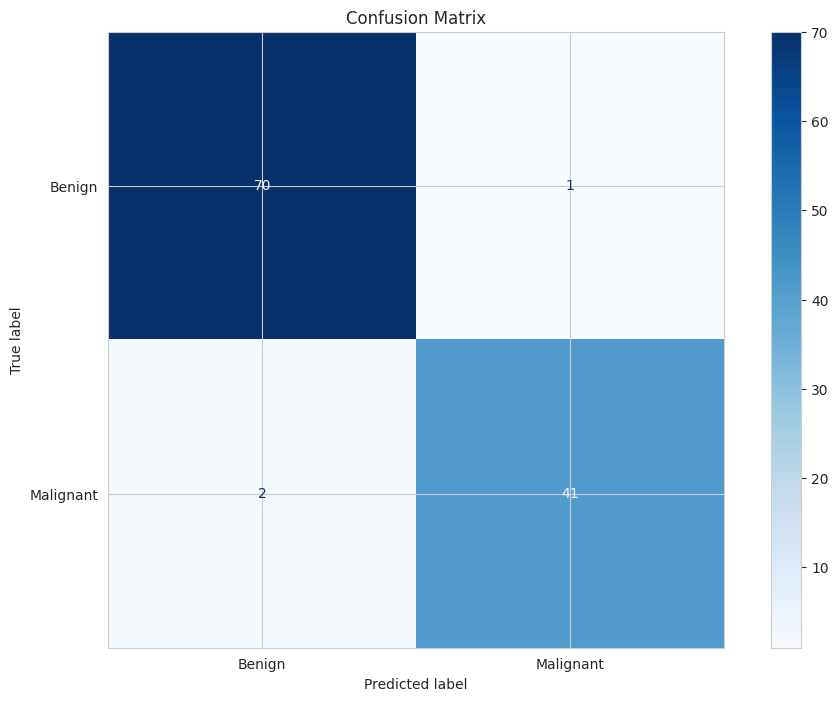


Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.99      0.98        71
   Malignant       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



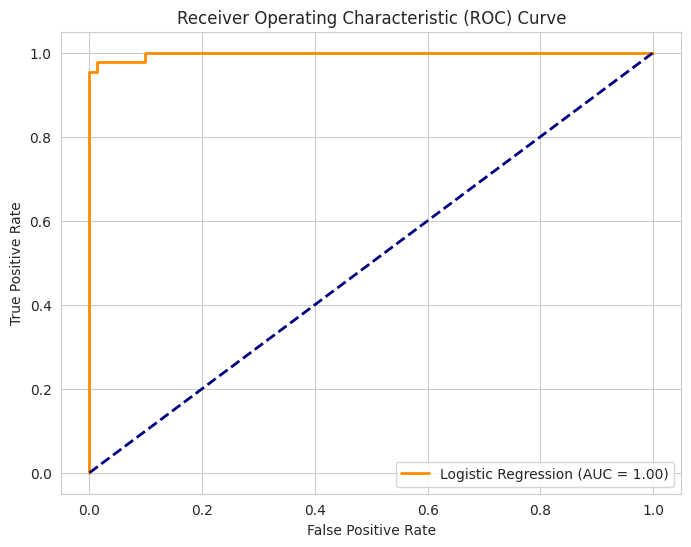


--- Theory & Tuning ---


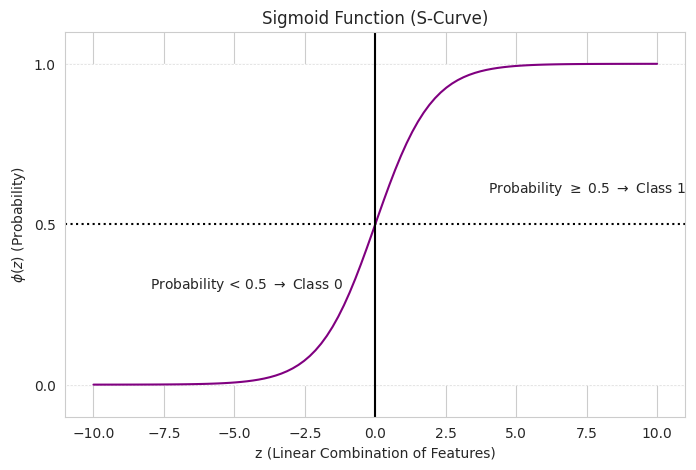


--- Threshold Tuning Analysis ---
Default threshold is 0.5. Let's see what happens if we change it.

Predictions with Threshold = 0.8:
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98        71
   Malignant       1.00      0.93      0.96        43

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


Predictions with Threshold = 0.2:
              precision    recall  f1-score   support

      Benign       0.99      0.94      0.96        71
   Malignant       0.91      0.98      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



In [26]:
if __name__ == "__main__":
    # Filepath to your uploaded file
    FILE_PATH = 'data.csv'

    try:
        # 1. Load
        df = load_data(FILE_PATH)

        # 2. Preprocess
        X_train, X_test, y_train, y_test, feature_names = preprocess_data(df)

        # 3. Train
        model = train_model(X_train, y_train)

        # 4. Evaluate
        y_pred_proba = evaluate_model(model, X_test, y_test)

        # 5. Mini-Guide Topics
        print("\n--- Theory & Tuning ---")
        plot_sigmoid_function()
        threshold_tuning_demo(y_test, y_pred_proba)

    except FileNotFoundError:
        print("Error: 'data.csv' not found. Please ensure the file is uploaded to the correct path.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")